# Copyright

<PRE>
Jelen iPython notebook a Budapesti Műszaki és Gazdaságtudományi Egyetemen tartott "Deep Learning a gyakorlatban Python és LUA alapon" tantárgy segédanyagaként készült. 
A tantárgy honlapja: http://smartlab.tmit.bme.hu/oktatas-deep-learning
Deep Learning kutatás: http://smartlab.tmit.bme.hu/deep-learning

A notebook bármely részének újra felhasználása, publikálása csak a szerzők írásos beleegyezése esetén megegengedett.

2017 (c) Gyires-Tóth Bálint (toth.b kukac tmit pont bme pont hu), Császár Márk
</PRE>

# XOR probléma

Az előzőleg bemutatott XOR problémát e notebookban egy Python alapokra építkező, gépi tanulást elősegítő keretrendszerrel, a Kerassal fogjuk megoldani. A Keras az egyik legelterjedtebb mély tanuló keretrendszer, köszönhetően magas szintű megvalósításának. Backend-nek TensorFlow-t és Thenao-t is tud használni.
A kódunk elején betöltjük a Keras csomagból a szükséges modulokat.

In [1]:
# Először is, az egymáshoz képest lineárisan elhelyezkedő neurális hálózat modelljét.
from keras.models import Sequential
# Szükségünk van továbbá az előrecsatolt rétegekre, illetve a rajtuk elvégzett aktivációs függvényre.
from keras.layers.core import Dense, Activation
# A Callback függvény rengeteg hasznos információt szolgáltat a tanítási folyamat során, amelyekre kíváncsiak
# szoktunk lenni. 
from keras.callbacks import Callback
# A tanulási folyamat során a széles körben alkalmazott Stochastic Gradient Descent metódust alkalmazzuk mini-batch-eken.
# Ennek segítségével tudjuk a tanulási paramétereket szabályozni.
from keras.optimizers import SGD
# A jól ismert Numpy betöltése.
import numpy as np
# Standardizáláshoz
from sklearn import preprocessing
# Matplotlib grafikus megjelenítőcsomag meghívása
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


Az előbb már említett Callback függvényre alapozva a TrainingHistory osztállyal tudunk kinyerni értékes metrikákat, amelyek a hálózat tanulási folyamatát jellemzik. 

In [2]:
class TrainingHistory(Callback):
    # Tanulási folyamat elején létrehozunk egy-egy üres listát a kinyerni kívánt metrikák tárolása céljából.
    def on_train_begin(self, logs={}):
        # Hiba mértéke a tanító adatokon.
        self.losses = []
        # Hiba mértéke a validációs adatokon.
        self.valid_losses = []
        # A modell jóságát, pontosságát mérő mutatószám a tanító adatokon. 
        self.accs = []
        # A modell jóságát, pontosságát mérő mutatószám a validációs adatokon. 
        self.valid_accs = []
        # A tanítási fázisok sorszámozása.
        self.epoch = 0
    
    # Minden egyes tanítási fázis végén mentsük el, hogy hogyan teljesít aktuálisan a háló. 
    def on_epoch_end(self, epoch, logs={}):
        if epoch % 1 == 0:
            self.losses.append(logs.get('loss'))
            self.valid_losses.append(logs.get('val_loss'))
            self.accs.append(logs.get('acc'))
            self.valid_accs.append(logs.get('val_acc'))
            self.epoch += 1
            
history = TrainingHistory()

In [3]:
# Modell felépítése

# A modell struktúráját az egymásra linárisan épülő rétegek adják.
model = Sequential()
# Az első rejtett réteg definiálása, amely két bemenetről kapja az adatokat.
model.add(Dense(output_dim=10, input_dim=2))
# A rétegen alkalmazott szigmoid (hiperbolikus tanges) aktivációs függvény.
model.add(Activation("tanh"))
# Utolsó réteg definiálása, amelynek egy kimenete van.
model.add(Dense(output_dim=1))
# A rétegen alkalmazott szigmoid (hiperbolikus tanges) aktivációs függvény.
model.add(Activation("tanh"))
# A tanulás előtt be kell állítani, hogy a tanulási folyamat milyen paraméterek mentén történjen.
# Az első paraméter a hiba meghatározására az átlagos négyzetes hiba értéket fogjuk alkalmazni.
model.compile(loss='mean_squared_error',
              # A korábbiakban már említett SGD optimatizáló metódusban tudjuk meghatározni a tanulási rátát
              # a momemtum módszer értékét, illetve, hogy használjon a háló Nesterov-momemtum módszert.
              optimizer= SGD(lr=0.1, momentum=0.001, nesterov=True),
              metrics=['accuracy'])

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:6: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=10, input_dim=2)`
  
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:10: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=1)`
  # Remove the CWD from sys.path while we load stuff.


Tanító, validációs és tesztelő adatok megadása, standardizálása és megjelenítése:

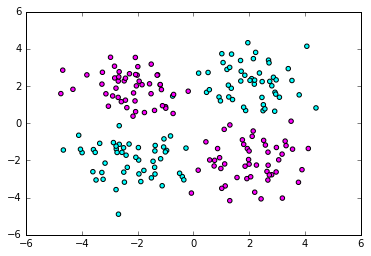

In [4]:
nb_samples=200
valid_split = 0.2
test_split = 0.1
samples=np.zeros(nb_samples, dtype=[('input', float, 2), ('output', float, 1)])
for i in range(0,nb_samples,4):
    noise = np.random.normal(0,1,8)
    samples[i] = (-2+noise[0],-2+noise[1]), 0
    samples[i+1] = (2+noise[2],-2+noise[3]), 1
    samples[i+2] = (-2+noise[4],2+noise[5]), 1
    samples[i+3] = (2+noise[6],2+noise[7]), 0

fig1=plt.figure()
plt.scatter(samples['input'][:,0],samples['input'][:,1],c=samples['output'][:], cmap=plt.cm.cool)

samples_train = samples[0:int(nb_samples*(1-valid_split-test_split))]
samples_valid = samples[int(nb_samples*(1-valid_split-test_split)):int(nb_samples*(1-test_split))]
samples_test  = samples[int(nb_samples*(1-test_split)):]
    
# standardizálás
scaler = preprocessing.StandardScaler().fit(samples_train['input'])
samples_train['input'] = scaler.transform(samples_train['input'])
samples_valid['input'] = scaler.transform(samples_valid['input'])
samples_test['input'] = scaler.transform(samples_test['input'])    

A továbbiakban un. callback függvényeket adunk meg, melyeket tanítás során hív meg a Keras deep learning keretrendszer:

In [5]:
# Early stopping, amellyel figyeljük a validációs hibát (alap beállítás)
from keras.callbacks import EarlyStopping
patience=10
early_stopping=EarlyStopping(patience=patience, verbose=1)

# Szintén a validációs hibát figyeljük, és elmentjük a legjobb modellt
from keras.callbacks import ModelCheckpoint
checkpointer=ModelCheckpoint(filepath='weights.hdf5', save_best_only=True, verbose=1)

# a tanulálsi ráta (lr, learning rate) automatikus csökkentésére szolgáló függvény
from keras.callbacks import ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=20, min_lr=10e-5)

# a tanulási ráta kézzel írt szabályok alapján történő csökkentésére szolgáló függvény
# ezt most a tanítás során nem fogjuk használni, de érdemes kipróbálni a ReduceLROnPlateau
# függvény helyett
from keras.callbacks import LearningRateScheduler
def scheduler(epoch):
    result=0.1
    if (epoch>20):
        result=0.05
    if (epoch>40):
        result=10e-3
    if (epoch>60):
        result=0.1
    print("Learning rate: %f" % (result))
    return result

change_lr = LearningRateScheduler(scheduler)

# A háló tanítása és tesztelése

Tanítási folyamat és annak a paraméterei. A paraméterek sorát a tanulási adatokkal kell kezdeni. Ez után számos paramétert definiálhatunk, melyek rövid magyarázatát kommentekben olvashatjátok:

In [6]:
model.fit(samples_train['input'], samples_train['output'],
          # A tanulási folyamat során beállíthatjuk, hogy a tanító adatsorból hány elem kerüljön bele egy-egy
          # batch-be.
          batch_size=20,
          # Tanulási fázisok száma.
          nb_epoch=2500,
          # Verbose paraméter a tanulás során közli azokat az információkat, amelyek mi szeretnénk kinyerni.
          # Értéke lehet 0, 1 és 2
          verbose=2, 
          # A tanulással párhuzamosan a validáció is fut.
          validation_data=(samples_valid['input'],samples_valid['output']), 
          # A korábbiakban már tárgyalt tanulást jellemző metrikákat a history nevű változóban szeretnénk tárolni.
          callbacks=[reduce_lr, checkpointer, early_stopping, history], 
          # A bemenő adatokat keverje meg a program (alapbeállítás: True).
          shuffle= True)

/usr/local/lib/python3.5/dist-packages/keras/models.py:848: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 140 samples, validate on 40 samples
Epoch 1/2500
Epoch 00000: val_loss improved from inf to 0.26755, saving model to weights.hdf5
0s - loss: 0.3502 - acc: 0.5429 - val_loss: 0.2675 - val_acc: 0.6500
Epoch 2/2500
Epoch 00001: val_loss improved from 0.26755 to 0.26133, saving model to weights.hdf5
0s - loss: 0.2699 - acc: 0.4000 - val_loss: 0.2613 - val_acc: 0.3000
Epoch 3/2500
Epoch 00002: val_loss improved from 0.26133 to 0.25686, saving model to weights.hdf5
0s - loss: 0.2645 - acc: 0.3500 - val_loss: 0.2569 - val_acc: 0.5500
Epoch 4/2500
Epoch 00003: val_loss improved from 0.25686 to 0.25293, saving model to weights.hdf5
0s - loss: 0.2596 - acc: 0.4786 - val_loss: 0.2529 - val_acc: 0.6250
Epoch 5/2500
Epoch 00004: val_loss improved from 0.25293 to 0.24964, saving model to weights.hdf5
0s - loss: 0.2564 - acc: 0.5857 - val_loss: 0.2496 - val_acc: 0.5250
Epoch 6/2500
Epoch 00005: val_loss improved from 0.24964 to 0.24673, saving model to weights.hdf5
0s - loss: 0.2508 - acc: 0

A hálózat hibájának megjelenítése mint a tanító, mind a validációs adathalmazon:

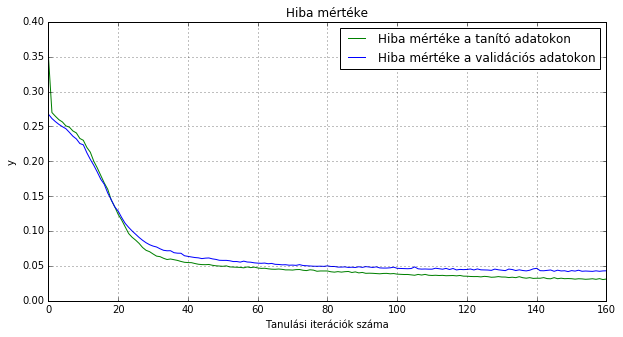

In [7]:
plt.figure(figsize=(10, 5))
plt.title('Hiba mértéke')
plt.plot(np.arange(history.epoch), history.losses, color ='g', label='Hiba mértéke a tanító adatokon') 
plt.plot(np.arange(history.epoch), history.valid_losses, color ='b', label='Hiba mértéke a validációs adatokon')
plt.legend(loc='upper right')
plt.xlabel('Tanulási iterációk száma')
plt.ylabel('y')
plt.grid(True)
plt.show()

Tesztelés és megjelenítés fázisa:

Test MSE: 0.030645


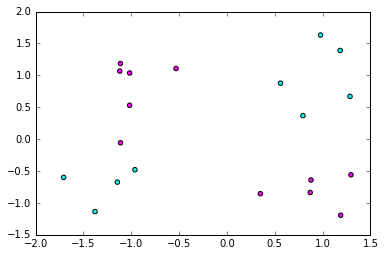

In [8]:
# a legjobb modell visszatöltése
from keras.models import load_model
model = load_model('weights.hdf5')
# teszt adatokkal prediktálás
preds=model.predict(samples_test['input'])
# hiba számítása a teszt adatokon
from sklearn.metrics import mean_squared_error
test_mse = mean_squared_error(samples_test['output'],preds)
print("Test MSE: %f" % (test_mse))
# predikció megjelenítése
fig1=plt.figure()
plt.scatter(samples_test['input'][:,0], \
            samples_test['input'][:,1], \
            c=np.round(preds[:]), cmap=plt.cm.cool)